[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Optimal Weights:
VOO: 61.7842%
BND: 0.0000%
GLD: 38.2158%
Expected Annual Return: 0.1051
Expected Volatility: 0.1252
Sharpe Ratio: 0.5301


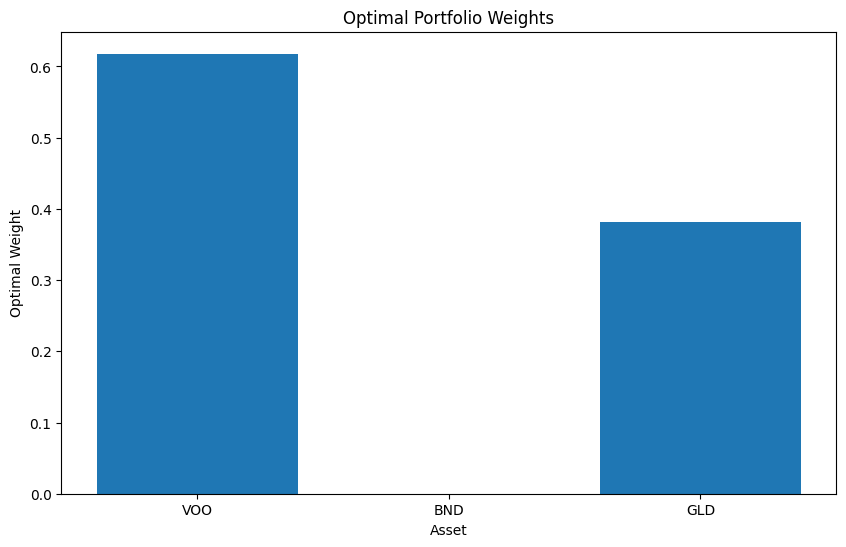

In [1]:
import yfinance as yf
import pandas as pd
from datetime import datetime, timedelta
import numpy as np
from scipy.optimize import minimize

# List of tickers
# TODO: dynamic tickers
tickers = ['VOO', 'BND', 'GLD', 'BTC-USD']

end_date = datetime.today()
# TODO: dynamic year
start_date = end_date - timedelta(days=365*10)

# Create an empty DataFrame to store the adjusted closing prices
adj_close_df = pd.DataFrame()

# Download the closing prices
for ticker in tickers:
    data = yf.download(ticker, start=start_date, end=end_date)
    adj_close_df[ticker] = data['Adj Close']

# Calculate the lognormal returns
log_returns = np.log(adj_close_df / adj_close_df.shift(1))

# Drop any missing values
log_returns = log_returns.dropna()

# Calculate covariance matrix
cov_matrix = log_returns.cov()*252

# Define the portfolio standard deviation
def standard_deviation(weights, cov_matrix):
    variance = weights.T @ cov_matrix @ weights
    return np.sqrt(variance)

# Define the expected return
# Key Assumption: Expected returns are based on historical returns
# TODO: Implement a more sophisticated model for expected returns
def expected_return(weights, log_returns):
    return np.sum(log_returns.mean() * weights) * 252

# Define the Sharpe Ratio
def sharpe_ratio(weights, log_returns, cov_matrix, risk_free_rate):
    ret = expected_return(weights, log_returns) - risk_free_rate
    std = standard_deviation(weights, cov_matrix)
    return ret / std

# Set the risk-free rate
# Use the fredapi to get the ten-year treasury rate
from fredapi import Fred
fred = Fred(api_key='e028e52e43c1380cb2bfcd2583dd9346')
ten_year_treasury_rate = fred.get_series_latest_release('GS10') / 100

risk_free_rate = ten_year_treasury_rate.iloc[-1]

# Define the function to minimize (negative Sharpe Ratio)
def negative_sharpe_ratio(weights, log_returns, cov_matrix, risk_free_rate):
    return -sharpe_ratio(weights, log_returns, cov_matrix, risk_free_rate)

# Define the constraints and bounds
# TODO: dynamic bounds
constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
bounds = tuple((0, 1) for x in range(len(tickers)))

# Set the initial weights
initial_weights = [1/len(tickers) for i in range(len(tickers))]

# Optimize the portfolio
optimal_weights = minimize(negative_sharpe_ratio, initial_weights, args=(log_returns, cov_matrix, risk_free_rate), method='SLSQP', bounds=bounds, constraints=constraints)

# Get the optimal weights
optimal_weights = optimal_weights.x


## Display analytics of the optimal portfolio
print('Optimal Weights:')
for ticker, weight in zip(tickers, optimal_weights):
    print(f'{ticker}: {weight:.4%}')
print(f'Expected Annual Return: {expected_return(optimal_weights, log_returns):.4f}')
print(f'Expected Volatility: {standard_deviation(optimal_weights, cov_matrix):.4f}')
print(f'Sharpe Ratio: {sharpe_ratio(optimal_weights, log_returns, cov_matrix, risk_free_rate):.4f}')


## Display the optimal portfolio in plot
import matplotlib.pyplot as plt

# Create a bar chart of the optimal weights
plt.figure(figsize=(10, 6))
plt.bar(tickers, optimal_weights)

# Add labels and title
plt.xlabel('Asset')
plt.ylabel('Optimal Weight')
plt.title('Optimal Portfolio Weights')

# Display the plot
plt.show()


